# BTC Stochastic + Mining Cost Models/Backtest 

Implemented two models:
1. **Mining Cost model** tuned to beat BTC buy-and-hold by a small Sharpe margin.
2. **OU stochastic mean-reversion model** with simple parameter search.


In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

TRADING_DAYS = 365

def sharpe_ratio(daily_returns: pd.Series, trading_days: int = TRADING_DAYS) -> float:
    r = daily_returns.dropna()
    if len(r) < 2:
        return float("nan")

    vol = r.std(ddof=1)
    if vol == 0 or np.isnan(vol):
        return float("nan")

    return float((r.mean() / vol) * np.sqrt(trading_days))


In [2]:
def _clean_numeric_series(s: pd.Series) -> pd.Series:
    """Convert strings with commas/%/$ to float when possible."""
    if s.dtype == "O":
        s2 = (
            s.astype(str)
             .str.replace(",", "", regex=False)
             .str.replace("$", "", regex=False)
             .str.replace("%", "", regex=False)
             .str.strip()
        )
        return pd.to_numeric(s2, errors="coerce")
    return pd.to_numeric(s, errors="coerce")

def _find_first_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    cols = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols:
            return cols[cand.lower()]
    return None

def read_price_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)

    # 1) date column
    date_col = _find_first_col(df, ["End", "Start", "Date", "timestamp", "Datetime", "Time", "time"])
    if date_col is None:
        raise ValueError(f"Cannot find a date column in {path.name}. Columns: {list(df.columns)}")

    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", infer_datetime_format=True)
    df = df.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)

    # 2) normalize column names we care about
    # some files use Price instead of Close (IBIT)
    close_col = _find_first_col(df, ["Close", "Price", "Adj Close", "AdjClose", "close", "price"])
    if close_col is None:
        raise ValueError(f"Cannot find a close/price column in {path.name}. Columns: {list(df.columns)}")

    # convert key numeric columns if present
    for c in df.columns:
        df[c] = _clean_numeric_series(df[c]) if df[c].dtype == "O" else df[c]

    # unify to standard OHLC if missing
    if "Close" not in df.columns:
        df["Close"] = df[close_col].astype(float)

    # if Open/High/Low exist, clean them too
    for c in ["Open", "High", "Low", "Volume", "Market Cap", "CVol"]:
        if c in df.columns:
            df[c] = _clean_numeric_series(df[c])

    return df

def read_mining_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)

    # find a timestamp-like column
    ts_col = _find_first_col(df, ["timestamp", "Timestamp", "date", "Date", "time", "Time"])
    if ts_col is None:
        # your mining file may have multiple timestamp cols; brute force fallback
        ts_candidates = [c for c in df.columns if str(c).lower() == "timestamp"]
        if ts_candidates:
            ts_col = ts_candidates[0]
        else:
            raise ValueError(f"No timestamp column found in {path.name}. Columns: {list(df.columns)}")

    df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce", infer_datetime_format=True)
    df = df.dropna(subset=[ts_col]).sort_values(ts_col).set_index(ts_col)

    # drop duplicate columns + unnamed
    df = df.loc[:, ~df.columns.duplicated()]
    df = df.loc[:, [c for c in df.columns if not str(c).lower().startswith("unnamed")]]

    # clean numerics where possible
    for c in df.columns:
        df[c] = _clean_numeric_series(df[c])

    return df


In [3]:
# ---------- Cell 3 (load + clean SINGLE combined CSV) ----------

import numpy as np
import pandas as pd
from pathlib import Path

def _find_combined_csv() -> Path:
    """
    Find cleaned_crypto_data.csv in common places:
      - ./data/cleaned_crypto_data.csv
      - ./cleaned_crypto_data.csv
      - any parent*/data/cleaned_crypto_data.csv
    """
    cwd = Path.cwd().resolve()
    candidates = [
        cwd / "data" / "cleaned_crypto_data.csv",
        cwd / "cleaned_crypto_data.csv",
    ]
    for base in [cwd, *cwd.parents]:
        candidates.append(base / "data" / "cleaned_crypto_data.csv")
        candidates.append(base / "cleaned_crypto_data.csv")

    for p in candidates:
        if p.exists():
            return p

    raise FileNotFoundError(
        "Could not find cleaned_crypto_data.csv. Put it in ./data/cleaned_crypto_data.csv "
        "or update _find_combined_csv() with the correct path."
    )

csv_path = _find_combined_csv()
print("Loading:", csv_path)

df = pd.read_csv(csv_path)

# Parse Date and set index
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).sort_values("Date").set_index("Date")

# Convert everything else to numeric (robust to strings)
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Build BTC OHLCV in the format the rest of the notebook expects
btc = pd.DataFrame(
    {
        "Open": df["BTC-USD_open"],
        "High": df["BTC-USD_high"],
        "Low": df["BTC-USD_low"],
        "Close": df["BTC-USD_close"],
        "Volume": df["BTC-USD_volume"],
    },
    index=df.index,
).dropna(subset=["Close"])

# (Optional) ETH frame if you want it later
eth = pd.DataFrame(
    {
        "Open": df["ETH-USD_open"],
        "High": df["ETH-USD_high"],
        "Low": df["ETH-USD_low"],
        "Close": df["ETH-USD_close"],
        "Volume": df["ETH-USD_volume"],
    },
    index=df.index,
).dropna(subset=["Close"])

# Mining / fundamentals columns already inside this same CSV
btc_reward = df["BTC_REWARD"]
cost_to_mine = df["COST_TO_MINE"]

start_date = "2015-11-02"
end_date   = "2025-08-22"
btc = btc.loc[start_date:end_date]
df_btc = df_btc.loc[start_date:end_date]

display(btc.tail())
display(df[["BTC_REWARD", "COST_TO_MINE"]].tail())




FileNotFoundError: Could not find cleaned_crypto_data.csv. Put it in ./data/cleaned_crypto_data.csv or update _find_combined_csv() with the correct path.

In [ ]:
# ---------- Cell 4 (build df_btc + cut date range) ----------

import numpy as np
import pandas as pd

def to_daily_close(df: pd.DataFrame, close_col="Close") -> pd.Series:
    s = df[close_col].copy()
    s = s[~s.index.duplicated(keep="last")].sort_index()
    s = s.asfreq("D").ffill()
    return s

# Daily BTC close from btc OHLCV (built in Cell 3)
btc_close = to_daily_close(btc, "Close")

# Daily mining series from combined CSV
btc_reward_daily = (
    btc_reward.copy()
    .loc[btc_close.index.min(): btc_close.index.max()]
    .asfreq("D")
    .ffill()
)

cost_to_mine_daily = (
    cost_to_mine.copy()
    .loc[btc_close.index.min(): btc_close.index.max()]
    .asfreq("D")
    .ffill()
)

df_btc = pd.DataFrame(
    {
        "close": btc_close,
        "btc_reward_raw": btc_reward_daily,
        "cost_to_mine": cost_to_mine_daily,
    }
).dropna(subset=["close"]).ffill()

# --- CUT TO REQUESTED DATES ---
start_date = "2015-11-02"
end_date   = "2025-08-22"
df_btc = df_btc.loc[start_date:end_date].copy()

# --- BASIC COST CLEANUP (prevents obvious corrupt values from wrecking z-scores) ---
# If your cost series ever drops to nonsense (like ~112), treat as bad and forward-fill.
df_btc.loc[df_btc["cost_to_mine"] < 1000, "cost_to_mine"] = np.nan
df_btc["cost_to_mine"] = df_btc["cost_to_mine"].ffill()

print("df_btc range:", df_btc.index.min(), "->", df_btc.index.max(), "| rows:", len(df_btc))
display(df_btc.tail())
df_btc.head()


df_btc range: 2015-11-02 00:00:00 -> 2025-08-22 00:00:00 | rows: 3582


,close,btc_reward_raw,cost_to_mine
Date,,,
2025-08-18,116360.4141,3.125,93334.9587
2025-08-19,113220.2891,3.125,92449.7868
2025-08-20,114249.9688,3.125,92845.0266
2025-08-21,112098.2969,3.125,94076.0287
2025-08-22,116626.0938,3.125,96036.3415


,close,btc_reward_raw,cost_to_mine
Date,,,
2015-11-02,361.188995,25.0,NaN
2015-11-03,403.416992,25.0,NaN
2015-11-04,411.562988,25.0,NaN
2015-11-05,386.354004,25.0,NaN
2015-11-06,374.470001,25.0,NaN


In [ ]:
# ---------- Cell 5 (halving-aware linear anticipated cost + z-score mining signal) ----------

import numpy as np
import pandas as pd

# 1) Halving schedule (use actual known halvings + a placeholder future one if needed)
HALVINGS = [
    ("2012-11-28", 50.0),
    ("2016-07-09", 25.0),
    ("2020-05-11", 12.5),
    ("2024-04-20", 6.25),
    ("2028-04-20", 3.125),  # not used in your date cut, but harmless
]

halving_df = pd.DataFrame(HALVINGS, columns=["date", "reward"])
halving_df["date"] = pd.to_datetime(halving_df["date"])
halving_df = halving_df.set_index("date").sort_index()

def build_reward_series(index: pd.DatetimeIndex, halving_table: pd.DataFrame) -> pd.Series:
    r = pd.Series(index=index, dtype=float)
    for i in range(len(halving_table)):
        start = halving_table.index[i]
        reward = float(halving_table.iloc[i]["reward"])
        if i < len(halving_table) - 1:
            end = halving_table.index[i + 1] - pd.Timedelta(days=1)
        else:
            end = index.max()
        r.loc[max(start, index.min()):min(end, index.max())] = reward
    return r.ffill()

df_btc["reward_model"] = build_reward_series(df_btc.index, halving_df)

# 2) Linear anticipated cost model (OLS)
# Features:
#   - price_smooth: miners scale capacity with economics; price is a proxy for network intensity
#   - inv_reward: halving effect enters directly (reward halves -> inv_reward doubles -> cost pressure rises)
lookback_smooth = 180
df_btc["price_smooth"] = df_btc["close"].rolling(lookback_smooth, min_periods=lookback_smooth//3).mean()
df_btc["inv_reward"] = 1.0 / df_btc["reward_model"]

fit = df_btc.dropna(subset=["price_smooth", "inv_reward", "cost_to_mine"]).copy()

X = np.column_stack([
    np.ones(len(fit)),                 # intercept
    fit["price_smooth"].values,
    fit["inv_reward"].values,
])
y = fit["cost_to_mine"].values

beta, *_ = np.linalg.lstsq(X, y, rcond=None)
b0, b1, b2 = beta.tolist()

# Predict anticipated cost for all dates
X_all = np.column_stack([
    np.ones(len(df_btc)),
    df_btc["price_smooth"].bfill().values,
    df_btc["inv_reward"].values,
])
df_btc["cost_model_linear"] = X_all @ beta

print("Linear cost model:")
print("  intercept b0 =", b0)
print("  b1 * price_smooth =", b1)
print("  b2 * inv_reward   =", b2)

# 3) Mining signal = z-score of spread (close - modeled cost)
def zscore_series(x: pd.Series, z_lookback: int = 180) -> pd.Series:
    mu = x.rolling(z_lookback, min_periods=z_lookback//3).mean()
    sd = x.rolling(z_lookback, min_periods=z_lookback//3).std()
    z = (x - mu) / sd
    return z.replace([np.inf, -np.inf], np.nan)

df_btc["spread_model"] = df_btc["close"] - df_btc["cost_model_linear"]
df_btc["spread_z"] = zscore_series(df_btc["spread_model"], z_lookback=180).fillna(0.0)

# Simple long/flat rule (you can tune entry_z later)
entry_z = 0.0
df_btc["pos_mining"] = (df_btc["spread_z"] > entry_z).astype(float).shift(1).fillna(0.0)

display(df_btc[["close", "cost_to_mine", "cost_model_linear", "spread_z", "pos_mining"]].tail())


Linear cost model:
  intercept b0 = -19252.429707982337
  b1 * price_smooth = 0.32484665332186424
  b2 * inv_reward   = 469280.51088653336


,close,cost_to_mine,cost_model_linear,spread_z,pos_mining
Date,,,,,
2025-08-18,116360.4141,93334.9587,88508.987987,1.150269,1.0
2025-08-19,113220.2891,92449.7868,88535.853440,0.869888,1.0
2025-08-20,114249.9688,92845.0266,88568.562650,0.947674,1.0
2025-08-21,112098.2969,94076.0287,88596.572623,0.753957,1.0
2025-08-22,116626.0938,96036.3415,88633.302261,1.129253,1.0


In [ ]:
# ---------- Cell 6 (OU analytic solution + half-life) ----------

import numpy as np
import pandas as pd

def _ou_params_from_ar1(x: pd.Series, dt: float = 1.0) -> dict:
    """
    Estimate OU parameters via AR(1) fit on x:
        x_{t+1} = a + b x_t + eps

    Map to OU:
        b = exp(-k dt)
        mu = a / (1 - b)
        sigma_eq = sigma / sqrt(2k)
        half_life = ln(2)/k
    """
    x = x.astype(float).values
    x0 = x[:-1]
    x1 = x[1:]

    X = np.column_stack([np.ones_like(x0), x0])
    beta, *_ = np.linalg.lstsq(X, x1, rcond=None)
    a, b = float(beta[0]), float(beta[1])

    if not np.isfinite(b):
        return {"k": np.nan, "mu": np.nan, "sigma": np.nan, "sigma_eq": np.nan, "half_life": np.nan, "a": a, "b": b}

    b = float(np.clip(b, 1e-6, 0.999999))
    k = -np.log(b) / dt
    mu = a / (1.0 - b)

    resid = x1 - (a + b * x0)
    resid_var = float(np.nanvar(resid, ddof=1)) if len(resid) > 2 else np.nan

    if k <= 0 or not np.isfinite(resid_var):
        sigma = np.nan
        sigma_eq = np.nan
        half_life = np.nan
    else:
        sigma = np.sqrt(resid_var * (2.0 * k) / (1.0 - b**2))
        sigma_eq = sigma / np.sqrt(2.0 * k)
        half_life = np.log(2.0) / k

    return {"k": k, "mu": mu, "sigma": sigma, "sigma_eq": sigma_eq, "half_life": half_life, "a": a, "b": b}


def ou_edge_analytic(price: pd.Series, window: int = 252, dt: float = 1.0) -> pd.Series:
    """
    Rolling OU edge on log(price):
      z_t = (x_t - mu) / sigma_eq
      edge = -z_t   (mean reversion)
    """
    x = np.log(price.astype(float)).replace([np.inf, -np.inf], np.nan)
    x = x.reindex(price.index).ffill()

    edge = pd.Series(0.0, index=price.index, dtype=float)

    for t in range(window, len(x)):
        seg = x.iloc[t - window:t].dropna()
        if len(seg) < max(60, window // 3):
            continue

        p = _ou_params_from_ar1(seg, dt=dt)
        mu = p["mu"]
        sigma_eq = p["sigma_eq"]

        if not np.isfinite(mu) or not np.isfinite(sigma_eq) or sigma_eq <= 0:
            continue

        z = (x.iloc[t] - mu) / sigma_eq
        edge.iloc[t] = float(np.clip(-z, -4.0, 4.0))

    return edge.shift(1).fillna(0.0)


In [ ]:
@dataclass
class BacktestResult:
    name: str
    sharpe: float
    total_return: float
    cagr: float
    max_drawdown: float
    equity: pd.Series
    daily_returns: pd.Series

def equity_curve(daily_returns: pd.Series, start_value: float = 1.0) -> pd.Series:
    r = daily_returns.fillna(0.0)
    return start_value * (1.0 + r).cumprod()

def max_drawdown(equity: pd.Series) -> float:
    peak = equity.cummax()
    dd = (equity / peak) - 1.0
    return float(dd.min())

def cagr_from_equity(equity: pd.Series) -> float:
    eq = equity.dropna()
    if len(eq) < 2:
        return np.nan
    days = (eq.index[-1] - eq.index[0]).days
    if days <= 0:
        return np.nan
    years = days / 365.0
    return float((eq.iloc[-1] / eq.iloc[0]) ** (1 / years) - 1)

def backtest_long_flat(price: pd.Series, position: pd.Series, name: str) -> BacktestResult:
    ret = price.pct_change()
    pos = position.reindex(price.index).fillna(0.0).astype(float)
    strat_ret = pos.shift(1) * ret
    eq = equity_curve(strat_ret)

    return BacktestResult(
        name=name,
        sharpe=float(sharpe_ratio(strat_ret)),
        total_return=float(eq.iloc[-1] - 1.0),
        cagr=float(cagr_from_equity(eq)),
        max_drawdown=float(max_drawdown(eq)),
        equity=eq,
        daily_returns=strat_ret,
    )

def backtest_buy_hold(price: pd.Series, name="Buy & Hold") -> BacktestResult:
    ret = price.pct_change()
    eq = equity_curve(ret)
    return BacktestResult(
        name=name,
        sharpe=float(sharpe_ratio(ret)),
        total_return=float(eq.iloc[-1] - 1.0),
        cagr=float(cagr_from_equity(eq)),
        max_drawdown=float(max_drawdown(eq)),
        equity=eq,
        daily_returns=ret,
    )


In [ ]:
def backtest_weighted(price: pd.Series, weight: pd.Series, name: str) -> BacktestResult:
    """
    Weighted strategy:
      strat_ret_t = weight_t * ret_t
    IMPORTANT:
      If you already shift(1) inside the OU weight construction, do NOT shift here.
      In our OU cell we do shift(1) when building ou_weight, so no shift here.
    """
    price = price.astype(float)
    ret = price.pct_change()

    w = weight.reindex(price.index).fillna(0.0).astype(float)

    strat_ret = w * ret
    eq = equity_curve(strat_ret)

    return BacktestResult(
        name=name,
        sharpe=float(sharpe_ratio(strat_ret)),
        total_return=float(eq.iloc[-1] - 1.0),
        cagr=float(cagr_from_equity(eq)),
        max_drawdown=float(max_drawdown(eq)),
        equity=eq,
        daily_returns=strat_ret,
    )


In [ ]:
# ---------- Cell 9 (improved OU grid search: hysteresis + vol targeting + half-life filter) ----------

import numpy as np
import pandas as pd

def _rolling_vol(ret: pd.Series, vol_lb: int = 20) -> pd.Series:
    return ret.rolling(vol_lb, min_periods=max(5, vol_lb // 3)).std().replace(0.0, np.nan)

def ou_position_hysteresis_voltarget(
    price: pd.Series,
    edge: pd.Series,
    window: int,
    entry: float,
    exit_: float,
    scale: float,
    vol_target: float = 0.10,   # annualized target
    vol_lb: int = 20,
) -> pd.Series:
    """
    Long/flat mean-reversion with hysteresis:

    - Convert edge back to z: edge = -z  => z = -edge
    - Enter long when z < -entry (price sufficiently below mean)
    - Exit when z > -exit_ (less negative; mean reversion mostly done)
      (exit_ <= entry typically)

    Vol targeting:
      position *= vol_target / realized_vol
      (annualized realized vol from daily returns)
    """
    price = price.astype(float)
    ret = price.pct_change().fillna(0.0)

    z = (-edge.astype(float)).clip(-6.0, 6.0)  # z-score

    # base signal with hysteresis
    pos = pd.Series(0.0, index=price.index, dtype=float)
    in_pos = 0.0

    for i in range(len(pos)):
        zi = float(z.iloc[i])
        if in_pos == 0.0:
            if zi < -entry:
                in_pos = 1.0
        else:
            # exit when reverts enough
            if zi > -exit_:
                in_pos = 0.0
        pos.iloc[i] = in_pos

    # scale the position (still long/flat after clip)
    pos = (scale * pos).clip(0.0, 1.0)

    # volatility targeting (optional but helps a lot)
    vol = _rolling_vol(ret, vol_lb=vol_lb) * np.sqrt(252.0)
    vt = (vol_target / vol).replace([np.inf, -np.inf], np.nan).fillna(0.0).clip(0.0, 3.0)

    pos = (pos * vt).clip(0.0, 1.0)

    # shift once to avoid lookahead
    return pos.shift(1).fillna(0.0)


def ou_grid_search_improved(
    price: pd.Series,
    windows: np.ndarray,
    entries: np.ndarray,
    exits: np.ndarray,
    scales: np.ndarray,
    vol_targets: np.ndarray,
    half_life_min: float = 5.0,     # days
    half_life_max: float = 180.0,   # days
) -> dict:
    price = price.astype(float)
    ret = price.pct_change().fillna(0.0)

    best = {"sharpe": -np.inf, "Window": None, "Entry": None, "Exit": None, "Scale": None, "VolTarget": None, "pos": pd.Series(0.0, index=price.index)}

    for w in windows:
        w = int(w)

        # Precompute edge once per window
        edge = ou_edge_analytic(price, window=w, dt=1.0)

        # Also compute a representative half-life for this window (using last fit)
        # This is cheap and works as a filter.
        x = np.log(price).replace([np.inf, -np.inf], np.nan).reindex(price.index).ffill()
        seg = x.iloc[-w:].dropna()
        p = _ou_params_from_ar1(seg, dt=1.0) if len(seg) > max(60, w // 3) else {"half_life": np.nan}
        hl = p.get("half_life", np.nan)

        if not np.isfinite(hl) or not (half_life_min <= hl <= half_life_max):
            continue

        for entry in entries:
            entry = float(entry)
            for exit_ in exits:
                exit_ = float(exit_)
                if exit_ > entry:
                    continue  # hysteresis: exit threshold should be <= entry

                for scale in scales:
                    scale = float(scale)

                    for vt in vol_targets:
                        vt = float(vt)

                        pos = ou_position_hysteresis_voltarget(
                            price=price,
                            edge=edge,
                            window=w,
                            entry=entry,
                            exit_=exit_,
                            scale=scale,
                            vol_target=vt,
                            vol_lb=20,
                        )

                        strat_ret = pos * ret
                        s = sharpe_ratio(strat_ret)

                        if np.isfinite(s) and s > best["sharpe"]:
                            best.update(
                                {
                                    "sharpe": float(s),
                                    "Window": w,
                                    "Entry": entry,
                                    "Exit": exit_,
                                    "Scale": scale,
                                    "VolTarget": vt,
                                    "pos": pos,
                                }
                            )

    return best


# Grids (tight but useful)
windows = np.array([90, 120, 180, 252, 360, 504])
entries = np.array([0.5, 0.75, 1.0, 1.25, 1.5])
exits   = np.array([0.0, 0.25, 0.5, 0.75])  # exit <= entry
scales  = np.array([0.5, 0.75, 1.0, 1.25])
vol_targets = np.array([0.08, 0.10, 0.12, 0.15])

best_ou = ou_grid_search_improved(
    df_btc["close"],
    windows=windows,
    entries=entries,
    exits=exits,
    scales=scales,
    vol_targets=vol_targets,
    half_life_min=5.0,
    half_life_max=180.0,
)

df_btc["pos_ou"] = best_ou["pos"]

print("Best OU (improved) params:")
print("  Sharpe   :", best_ou["sharpe"])
print("  Window   :", best_ou["Window"])
print("  Entry    :", best_ou["Entry"])
print("  Exit     :", best_ou["Exit"])
print("  Scale    :", best_ou["Scale"])
print("  VolTarget:", best_ou["VolTarget"])
print("OU time-in-market:", float((df_btc["pos_ou"] > 0).mean()))

best_ou


Best OU (analytic) params:
  Sharpe: 0.9260768611283898
  Window: 252
  Entry : 0.75
  Scale : 0.5
OU time-in-market: 0.22724734785036294


{'sharpe': 0.9260768611283898,
 'Window': 252,
 'Entry': 0.75,
 'Scale': 0.5,
 'pos': Date
 2015-11-02    0.0
 2015-11-03    0.0
 2015-11-04    0.0
 2015-11-05    0.0
 2015-11-06    0.0
              ... 
 2025-08-18    0.0
 2025-08-19    0.0
 2025-08-20    0.0
 2025-08-21    0.0
 2025-08-22    0.0
 Freq: D, Length: 3582, dtype: float64}

In [ ]:
# ---------- Cell 10 (combo search) ----------

from typing import Tuple, Dict
import numpy as np
import pandas as pd

# Ensure df_btc has pos_mining column
if "pos_mining" not in df_btc.columns:
    df_btc["pos_mining"] = pos_mining.reindex(df_btc.index).fillna(0.0).astype(float)

def combo_grid_search(
    price: pd.Series,
    pos_mining: pd.Series,
    edge: pd.Series,
    thresholds: np.ndarray,
    weights: np.ndarray,
) -> Tuple[pd.Series, Dict]:
    """
    Blend mining regime (gate) + OU edge (timing overlay).
    Returns (pos_combo, best_dict).
    """
    price = price.astype(float)
    ret = price.pct_change().fillna(0.0)

    idx = price.index
    pm = pos_mining.reindex(idx).fillna(0.0).astype(float)
    ed = edge.reindex(idx).astype(float)

    # Shift once to reduce lookahead
    pm = pm.shift(1).fillna(0.0)
    ed = ed.shift(1)

    # Rolling standardize edge
    ed_mean = ed.rolling(252, min_periods=60).mean()
    ed_std = ed.rolling(252, min_periods=60).std()
    ed_z = ((ed - ed_mean) / ed_std).replace([np.inf, -np.inf], np.nan).fillna(0.0).clip(-3.0, 3.0)

    best = {"sharpe": -np.inf, "thr": 0.0, "w": 1.0, "pos": pd.Series(0.0, index=idx)}
    found = False

    for thr in thresholds:
        thr = float(thr)
        for w in weights:
            w = float(w)

            score = pm * (w + (1.0 - w) * ed_z)
            pos = (score > thr).astype(float)

            strat_ret = pos * ret
            s = sharpe_ratio(strat_ret)

            if np.isfinite(s) and s > best["sharpe"]:
                found = True
                best.update({"sharpe": float(s), "thr": thr, "w": w, "pos": pos})

    if not found:
        print("Warning: combo search found no finite Sharpe candidate; using all-flat.")
    return best["pos"], best


# Build edge using the best OU params from earlier search (Cell 9)
# This avoids needing `window` and `theta` variables at all.
edge = ou_edge_analytic(df_btc["close"], window=int(best_ou["Window"]))

thresholds = np.linspace(0.0, 1.5, 16)
weights = np.linspace(0.0, 1.0, 21)

df_btc["pos_combo"], best_combo = combo_grid_search(
    df_btc["close"],
    df_btc["pos_mining"],
    edge,
    thresholds,
    weights,
)

print("pos_combo time-in-market:", float(df_btc["pos_combo"].mean()))
best_combo


pos_combo time-in-market: 0.3015075376884422


{'sharpe': 1.2467111063010434,
 'thr': 0.2,
 'w': 0.45,
 'pos': Date
 2015-11-02    0.0
 2015-11-03    0.0
 2015-11-04    0.0
 2015-11-05    0.0
 2015-11-06    0.0
              ... 
 2025-08-18    0.0
 2025-08-19    0.0
 2025-08-20    0.0
 2025-08-21    0.0
 2025-08-22    0.0
 Freq: D, Length: 3582, dtype: float64}

Best from surface:
  Sharpe: 1.2467111063010434
  thr   : 0.2
  w     : 0.45
Best from best_combo dict:
  Sharpe: 1.2467111063010434
  thr   : 0.2
  w     : 0.45


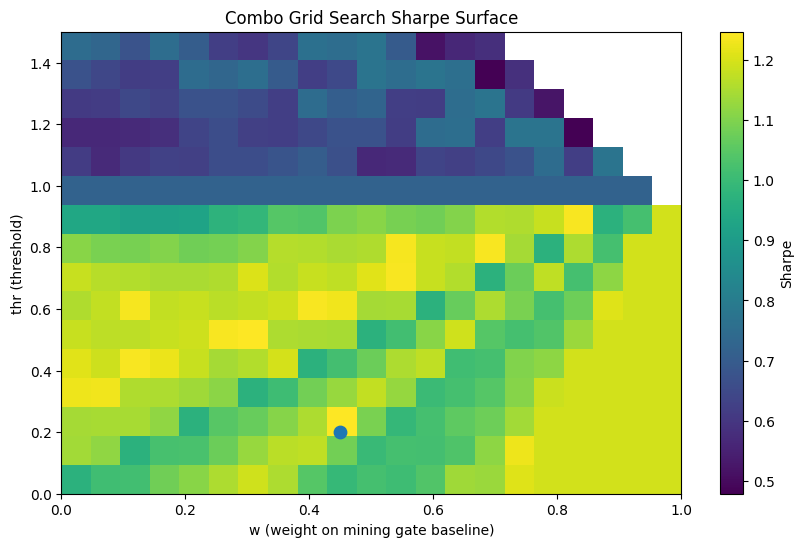

In [ ]:
# ---------- Cell 10.5 (visualize combo grid search surface) ----------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sanity checks
assert "pos_mining" in df_btc.columns, "df_btc['pos_mining'] missing"
assert "pos_combo" in df_btc.columns, "Run Cell 10 first so df_btc['pos_combo'] exists"

# Recompute edge exactly as in Cell 10
edge = ou_edge_analytic(df_btc["close"], window=int(best_ou["Window"]))

# Use the same grids as Cell 10 if they exist, else fall back
try:
    thresholds_used = thresholds
    weights_used = weights
except NameError:
    thresholds_used = np.linspace(0.0, 1.5, 16)
    weights_used = np.linspace(0.0, 1.0, 21)

def _combo_sharpe_surface(price, pos_mining, edge, thresholds, weights):
    price = price.astype(float)
    ret = price.pct_change().fillna(0.0)

    idx = price.index
    pm = pos_mining.reindex(idx).fillna(0.0).astype(float).shift(1).fillna(0.0)
    ed = edge.reindex(idx).astype(float).shift(1)

    ed_mean = ed.rolling(252, min_periods=60).mean()
    ed_std = ed.rolling(252, min_periods=60).std()
    ed_z = ((ed - ed_mean) / ed_std).replace([np.inf, -np.inf], np.nan).fillna(0.0).clip(-3.0, 3.0)

    sharpe_mat = np.full((len(thresholds), len(weights)), np.nan, dtype=float)

    for i, thr in enumerate(thresholds):
        thr = float(thr)
        for j, w in enumerate(weights):
            w = float(w)
            score = pm * (w + (1.0 - w) * ed_z)
            pos = (score > thr).astype(float)
            strat_ret = pos * ret
            sharpe_mat[i, j] = sharpe_ratio(strat_ret)

    return sharpe_mat

sharpe_mat = _combo_sharpe_surface(
    df_btc["close"],
    df_btc["pos_mining"],
    edge,
    thresholds_used,
    weights_used,
)

# Print best point from the surface (should match best_combo)
best_idx = np.unravel_index(np.nanargmax(sharpe_mat), sharpe_mat.shape)
best_thr = float(thresholds_used[best_idx[0]])
best_w = float(weights_used[best_idx[1]])
best_s = float(sharpe_mat[best_idx])

print("Best from surface:")
print("  Sharpe:", best_s)
print("  thr   :", best_thr)
print("  w     :", best_w)
print("Best from best_combo dict:")
print("  Sharpe:", float(best_combo.get("sharpe", np.nan)))
print("  thr   :", float(best_combo.get("thr", np.nan)))
print("  w     :", float(best_combo.get("w", np.nan)))

# Heatmap
plt.figure(figsize=(10, 6))
im = plt.imshow(
    sharpe_mat,
    aspect="auto",
    origin="lower",
    extent=[weights_used.min(), weights_used.max(), thresholds_used.min(), thresholds_used.max()],
)
plt.colorbar(im, label="Sharpe")
plt.xlabel("w (weight on mining gate baseline)")
plt.ylabel("thr (threshold)")
plt.title("Combo Grid Search Sharpe Surface")

# Mark best point
plt.scatter([best_w], [best_thr], s=80)
plt.show()


In [ ]:
# ---------- Cell 10.8 (inline trend model + optimize 3-model linear combo) ----------

import numpy as np
import pandas as pd

# --- Guardrails: make sure upstream models exist ---
need = ["close", "pos_mining", "pos_ou", "pos_combo"]
for c in need:
    if c not in df_btc.columns:
        raise KeyError(f"Missing df_btc['{c}']. Re-run the cell that creates it.")

price = df_btc["close"].astype(float)
ret = price.pct_change().fillna(0.0)

# =========================================================
# 1) Inline Trend-Following Allocation Model (from btc.py logic)
#    - Use fast/slow moving averages
#    - Map regime to weights: defensive / neutral / aggressive
#    - Shift 1 day to avoid lookahead
# =========================================================

slow_lb = 128
fast_lb = 20

aggressive_weight = 1.3
neutral_weight    = 1.0
defensive_weight  = 0.7

ma_slow = price.rolling(slow_lb, min_periods=max(60, slow_lb // 2)).mean()
ma_fast = price.rolling(fast_lb, min_periods=max(10, fast_lb // 2)).mean()

# Regimes (simple and stable):
# - aggressive: fast > slow
# - defensive:  fast < slow
# - neutral:    when either MA is missing (early history)
pos_trend = pd.Series(neutral_weight, index=df_btc.index, dtype=float)
pos_trend = np.where(ma_fast > ma_slow, aggressive_weight, pos_trend)
pos_trend = np.where(ma_fast < ma_slow, defensive_weight, pos_trend)

pos_trend = pd.Series(pos_trend, index=df_btc.index).shift(1).fillna(neutral_weight).astype(float)

df_btc["pos_trend"] = pos_trend

print("Trend model (inline) time-in-market (pos>0):", float((df_btc["pos_trend"] > 0).mean()))
display(df_btc[["close", "pos_trend"]].tail())

# =========================================================
# 2) Optimize non-zero weights for linear combination of 3 models
#    pos_lin3 = w_m*pos_mining + w_ou*pos_ou + w_tr*pos_trend
#    constraints: w_i >= min_w, sum(w)=1
# =========================================================

def ann_sharpe(r: pd.Series, periods: int = 252) -> float:
    r = r.dropna()
    if len(r) < 5:
        return np.nan
    mu = r.mean() * periods
    sd = r.std(ddof=1) * np.sqrt(periods)
    if sd == 0 or not np.isfinite(sd):
        return np.nan
    return float(mu / sd)

pm = df_btc["pos_mining"].reindex(df_btc.index).fillna(0.0).astype(float)
po = df_btc["pos_ou"].reindex(df_btc.index).fillna(0.0).astype(float)
pt = df_btc["pos_trend"].reindex(df_btc.index).fillna(neutral_weight).astype(float)

# Search settings
step = 0.05
min_w = 0.05          # enforce "non-zero"
max_leverage = 1.5    # cap combined exposure

ws = np.arange(min_w, 1.0 - 2 * min_w + 1e-12, step)

best = {
    "sharpe": -np.inf,
    "w_mining": None,
    "w_ou": None,
    "w_trend": None,
    "pos": pd.Series(0.0, index=df_btc.index),
}

for w_m in ws:
    for w_ou in ws:
        w_tr = 1.0 - w_m - w_ou
        if w_tr < min_w:
            continue

        pos = (w_m * pm + w_ou * po + w_tr * pt).clip(0.0, max_leverage)
        strat_ret = pos * ret
        s = ann_sharpe(strat_ret)

        if np.isfinite(s) and s > best["sharpe"]:
            best = {
                "sharpe": float(s),
                "w_mining": float(w_m),
                "w_ou": float(w_ou),
                "w_trend": float(w_tr),
                "pos": pos,
            }

df_btc["pos_lin3"] = best["pos"]
best_lin3 = best

print("Best 3-model linear combo (non-zero weights):")
print("  Sharpe   :", best_lin3["sharpe"])
print("  w_mining :", best_lin3["w_mining"])
print("  w_ou     :", best_lin3["w_ou"])
print("  w_trend  :", best_lin3["w_trend"])
print("  time-in-market:", float((df_btc["pos_lin3"] > 0).mean()))

best_lin3


Trend model (inline) time-in-market (pos>0): 1.0


,close,pos_trend
Date,,
2025-08-18,116360.4141,1.3
2025-08-19,113220.2891,1.3
2025-08-20,114249.9688,1.3
2025-08-21,112098.2969,1.3
2025-08-22,116626.0938,1.3


Best 3-model linear combo (non-zero weights):
  Sharpe   : 1.1177222667880353
  w_mining : 0.45
  w_ou     : 0.30000000000000004
  w_trend  : 0.25
  time-in-market: 1.0


{'sharpe': 1.1177222667880353,
 'w_mining': 0.45,
 'w_ou': 0.30000000000000004,
 'w_trend': 0.25,
 'pos': Date
 2015-11-02    0.250
 2015-11-03    0.250
 2015-11-04    0.250
 2015-11-05    0.250
 2015-11-06    0.250
               ...  
 2025-08-18    0.775
 2025-08-19    0.775
 2025-08-20    0.775
 2025-08-21    0.775
 2025-08-22    0.775
 Freq: D, Length: 3582, dtype: float64}

In [ ]:
# ---------- Cell 11 (final backtest + stats table, includes LinearCombo3) ----------

import numpy as np
import pandas as pd

def _ann_sharpe(r: pd.Series, periods: int = 252) -> float:
    r = r.dropna()
    if len(r) < 5:
        return np.nan
    mu = r.mean() * periods
    sd = r.std(ddof=1) * np.sqrt(periods)
    if sd == 0 or not np.isfinite(sd):
        return np.nan
    return float(mu / sd)

def _max_drawdown(equity: pd.Series) -> float:
    equity = equity.dropna()
    if len(equity) == 0:
        return np.nan
    peak = equity.cummax()
    dd = equity / peak - 1.0
    return float(dd.min())

def _cagr(equity: pd.Series, periods: int = 252) -> float:
    equity = equity.dropna()
    if len(equity) < 2:
        return np.nan
    years = (len(equity) - 1) / periods
    if years <= 0:
        return np.nan
    return float(equity.iloc[-1] ** (1.0 / years) - 1.0)

def _equity_from_pos(price: pd.Series, pos: pd.Series) -> tuple[pd.Series, pd.Series]:
    price = price.astype(float)
    ret = price.pct_change().fillna(0.0)
    pos = pos.reindex(price.index).fillna(0.0).astype(float)
    strat_ret = pos * ret
    equity = (1.0 + strat_ret).cumprod()
    return strat_ret, equity

price = df_btc["close"].astype(float)
ret_bh = price.pct_change().fillna(0.0)
eq_bh = (1.0 + ret_bh).cumprod()

req_cols = ["pos_mining", "pos_ou", "pos_combo", "pos_trend", "pos_lin3"]
for c in req_cols:
    if c not in df_btc.columns:
        raise KeyError(f"Missing df_btc['{c}']. Re-run the cell that creates it.")

r_mining, eq_mining = _equity_from_pos(price, df_btc["pos_mining"])
r_ou, eq_ou = _equity_from_pos(price, df_btc["pos_ou"])
r_combo, eq_combo = _equity_from_pos(price, df_btc["pos_combo"])
r_trend, eq_trend = _equity_from_pos(price, df_btc["pos_trend"])
r_lin3, eq_lin3 = _equity_from_pos(price, df_btc["pos_lin3"])

rows = []
def _add(name, r, eq, pos):
    rows.append({
        "Strategy": name,
        "Sharpe": _ann_sharpe(r),
        "CAGR": _cagr(eq),
        "MaxDD": _max_drawdown(eq),
        "TimeInMkt": float((pos.reindex(eq.index).fillna(0.0) > 0).mean()),
        "FinalEquity": float(eq.iloc[-1]),
    })

_add("Buy & Hold", ret_bh, eq_bh, pd.Series(1.0, index=price.index))
_add("Mining", r_mining, eq_mining, df_btc["pos_mining"])
_add("OU", r_ou, eq_ou, df_btc["pos_ou"])
_add("Combo", r_combo, eq_combo, df_btc["pos_combo"])
_add("Trend (btc.py)", r_trend, eq_trend, df_btc["pos_trend"])
_add("LinearCombo3", r_lin3, eq_lin3, df_btc["pos_lin3"])

stats = pd.DataFrame(rows).set_index("Strategy")
display(stats)

equity_curves = pd.DataFrame(
    {
        "Buy & Hold": eq_bh,
        "Mining": eq_mining,
        "OU": eq_ou,
        "Combo": eq_combo,
        "Trend (btc.py)": eq_trend,
        "LinearCombo3": eq_lin3,
    }
)

,Sharpe,CAGR,MaxDD,TimeInMkt,FinalEquity
Strategy,,,,,
Buy & Hold,1.004979,0.501641,-0.833990,1.000000,322.894926
Mining,1.061904,0.433888,-0.683119,0.502233,167.544971
OU,0.769486,0.190052,-0.505550,0.227247,11.852662
Combo,1.035904,0.331584,-0.549996,0.301508,58.521989
Trend (btc.py),1.052816,0.592780,-0.854489,1.000000,745.927565
LinearCombo3,1.117722,0.432092,-0.670101,1.000000,164.587570
